# 0. History

In [31]:
model_history = {
    "model_name" : [],
    "n_mfcc" : [],
    "val_acc" : [],
    "test_acc" : [],
    "train_time(s)" : []
}

# 1. Base Line model

## 1.1. Import what is needed

In [1]:
# Import PyTorch
import torch
from torch import nn
from dataset import SpeechDataset
import requests
from pathlib import Path
import matplotlib.pyplot as plt
from pathlib import PurePath
import pandas as pd

In [2]:
# Download helper functions from Learn PyTorch repo
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download...")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)
# Import accuracy metric
from helper_functions import accuracy_fn

helper_functions.py already exists, skipping download...


In [3]:
import os
print("현재 디렉토리:", os.getcwd())

현재 디렉토리: c:\ML\Machine_Learning_Class\Project\Scripts


In [4]:
# Setup device=agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1.2 Get Dataset

In [5]:
# Get Dataset
train_dataset = SpeechDataset("train_list.txt")
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = SpeechDataset("val_list.txt")
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)
test_dataset = SpeechDataset("test_list.txt")
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [6]:
# Check out what's created
print(f"Dataloaders: {train_dataloader, val_dataloader}")
print(f"Length of train_dataloader : {len(train_dataloader)}")
print(f"Length of test_dataloader: {len(val_dataloader)}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x000001EFA57901A0>, <torch.utils.data.dataloader.DataLoader object at 0x000001EFA53EA350>)
Length of train_dataloader : 444
Length of test_dataloader: 62


In [7]:
# Check out what's inside the train dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 40, 101]), torch.Size([32]))

## 1.3 Build a baseline model

In [15]:
# Build a baseline model
class CNNKeyWordSpotter(nn.Module):
    def __init__(self, num_classes = 6):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))   
        )
        self.fc = nn.Linear(32, num_classes)

    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [20]:
model_baseline = CNNKeyWordSpotter(num_classes = 6)

In [21]:
# Setup Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_baseline.parameters(), lr = 0.001)

## 1.4 Create a function to time out

In [8]:
from timeit import default_timer as timer
def print_train_time(start : float,
                     end : float,
                     device : torch.device = None):
  """Prints difference between start and end time."""
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

In [9]:
start_time = timer()
# some code...
end_time = timer()
print_train_time(start = start_time, end = end_time, device = "cpu")

Train time on cpu: 0.000 seconds


6.129999928816687e-05

## 1.5 Training Loop

### 1.5.0 Collect Data

In [13]:
history_baseline = {"epoch" : [],
                    "train_loss" : [],
                    "train_acc" : [],
                    "val_loss" : [],
                    "val_acc" : []}

### 1.5.1 Defince train_step, test_step

In [10]:
def train_step(model : torch.nn.Module,
               data_loader : torch.utils.data.DataLoader,
               loss_fn : torch.nn.Module,
               optimizer : torch.optim.Optimizer,
               accuracy_fn,
               device : torch.device = device):
    train_loss, train_acc = 0, 0

    # Put model into training mode
    model.train()

    # Add a loop to loop through the training batches
    for batch, (X, y) in enumerate(data_loader):
        # Put data on target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss and accuracy (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # Accumulate train loss
        train_acc += accuracy_fn(y_true = y,
                                 y_pred = y_pred.argmax(dim = 1))
        
        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Devide total train loss and acc by length of train dataloader
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")
    return train_loss, train_acc

In [11]:
def test_step(model : torch.nn.Module,
              data_loader : torch.utils.data.DataLoader,
              loss_fn : torch.nn.Module,
              accuracy_fn,
              device : torch.device = device):
    """ Performs a testing with model trying to learn on data_loader."""
    test_loss, test_acc = 0, 0

    # Put model into training model
    model.eval()

    # Turn on inference mode context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send the data to the target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate the loss/acc
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true = y,
                                    y_pred = test_pred.argmax(dim = 1))  
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test acc : {test_acc:.2f}%")
        return test_loss, test_acc

In [12]:
class EarlyStopping:
    def __init__(self, patience = 3, mode = 'max', save_path = "best_model.pth"):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.save_path = Path("models") / save_path
        self.mode = mode  # 'max' for acc, 'min' for loss

    def __call__(self, score, model):
        if self.best_score is None:
            self.best_score = score
            self.save_model(model)
        elif (self.mode == 'max' and score > self.best_score) or \
             (self.mode == 'min' and score < self.best_score):
            self.best_score = score
            self.counter = 0
            self.save_model(model)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                print("Early stopping triggered.")

    def save_model(self, model):
        torch.save(obj = model.state_dict(), f = self.save_path)
        print(f"Saving Model to {self.save_path}")

### 1.5.2 Implement

In [13]:
def to_scalar(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().item()
    return x

In [13]:
# Set the number of epochs
max_epochs = 1000

In [14]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

c:\Users\Minseo\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Early Stopping
early_stopper = EarlyStopping(patience=3, mode='max', save_path="Base_Line_Model.pth")

# Measure time
from timeit import default_timer as Timer
base_line_train_time_start = timer()

# Create a optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(max_epochs)):
    print(f"Epoch: {epoch}\n-------------")
    train_loss, train_acc = train_step(model = model_baseline,
                                       data_loader = train_dataloader,
                                       loss_fn = loss_fn,
                                       optimizer = optimizer,
                                       accuracy_fn = accuracy_fn,
                                       device = device)
    val_loss, val_acc = test_step(model = model_baseline,
                         data_loader = val_dataloader,
                         loss_fn = loss_fn,
                         accuracy_fn = accuracy_fn,
                         device = device)

    # Save history
    history_baseline["epoch"].append(to_scalar(epoch))
    history_baseline["train_loss"].append(to_scalar(train_loss))
    history_baseline["train_acc"].append(to_scalar(train_acc))
    history_baseline["val_loss"].append(to_scalar(val_loss))
    history_baseline["val_acc"].append(to_scalar(val_acc))

    early_stopper(val_acc, model_baseline)
    if early_stopper.early_stop:
        break
    
base_line_train_time_end = timer()
total_train_time_model_baseline = print_train_time(start = base_line_train_time_start,
                                                   end = base_line_train_time_end,
                                                   device = device)

/Users/Kpiano/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 0
-------------
Train loss: 1.39198 | Train acc: 41.25%


  0%|          | 1/1000 [00:36<10:00:08, 36.04s/it]

Test loss: 1.48676 | Test acc : 33.90%
Saving Model to models/Base_Line_Model.pth
Epoch: 1
-------------
Train loss: 1.09950 | Train acc: 55.53%


  0%|          | 2/1000 [01:00<8:01:51, 28.97s/it] 

Test loss: 1.09231 | Test acc : 53.92%
Saving Model to models/Base_Line_Model.pth
Epoch: 2
-------------
Train loss: 0.97475 | Train acc: 60.90%


  0%|          | 3/1000 [01:21<7:06:15, 25.65s/it]

Test loss: 1.11393 | Test acc : 54.65%
Saving Model to models/Base_Line_Model.pth
Epoch: 3
-------------
Train loss: 0.88686 | Train acc: 65.21%


  0%|          | 4/1000 [01:42<6:33:57, 23.73s/it]

Test loss: 0.96689 | Test acc : 60.48%
Saving Model to models/Base_Line_Model.pth
Epoch: 4
-------------
Train loss: 0.82469 | Train acc: 67.89%


  0%|          | 5/1000 [02:02<6:11:00, 22.37s/it]

Test loss: 0.94441 | Test acc : 62.67%
Saving Model to models/Base_Line_Model.pth
Epoch: 5
-------------
Train loss: 0.75777 | Train acc: 71.56%


  1%|          | 6/1000 [02:23<6:00:53, 21.78s/it]

Test loss: 0.78335 | Test acc : 68.74%
Saving Model to models/Base_Line_Model.pth
Epoch: 6
-------------
Train loss: 0.71353 | Train acc: 73.70%


  1%|          | 7/1000 [02:50<6:30:15, 23.58s/it]

Test loss: 0.80318 | Test acc : 66.00%
Epoch: 7
-------------
Train loss: 0.66762 | Train acc: 75.92%


  1%|          | 8/1000 [03:23<7:18:04, 26.50s/it]

Test loss: 0.70034 | Test acc : 74.49%
Saving Model to models/Base_Line_Model.pth
Epoch: 8
-------------
Train loss: 0.63349 | Train acc: 76.80%


  1%|          | 9/1000 [03:47<7:04:49, 25.72s/it]

Test loss: 0.65803 | Test acc : 76.71%
Saving Model to models/Base_Line_Model.pth
Epoch: 9
-------------
Train loss: 0.60113 | Train acc: 78.20%


  1%|          | 10/1000 [04:09<6:44:31, 24.52s/it]

Test loss: 0.69135 | Test acc : 73.48%
Epoch: 10
-------------
Train loss: 0.57142 | Train acc: 79.56%


  1%|          | 11/1000 [04:30<6:29:36, 23.64s/it]

Test loss: 0.59092 | Test acc : 79.91%
Saving Model to models/Base_Line_Model.pth
Epoch: 11
-------------
Train loss: 0.55121 | Train acc: 80.17%


  1%|          | 12/1000 [05:02<7:10:48, 26.16s/it]

Test loss: 0.63153 | Test acc : 76.93%
Epoch: 12
-------------
Train loss: 0.52756 | Train acc: 80.88%


  1%|▏         | 13/1000 [05:27<7:04:13, 25.79s/it]

Test loss: 0.55335 | Test acc : 79.86%
Epoch: 13
-------------
Train loss: 0.50769 | Train acc: 82.15%


  1%|▏         | 14/1000 [05:49<6:45:53, 24.70s/it]

Test loss: 0.52392 | Test acc : 82.05%
Saving Model to models/Base_Line_Model.pth
Epoch: 14
-------------
Train loss: 0.48653 | Train acc: 82.92%


  2%|▏         | 15/1000 [06:10<6:24:07, 23.40s/it]

Test loss: 0.51783 | Test acc : 82.35%
Saving Model to models/Base_Line_Model.pth
Epoch: 15
-------------
Train loss: 0.47861 | Train acc: 83.12%


  2%|▏         | 16/1000 [06:33<6:22:08, 23.30s/it]

Test loss: 0.51559 | Test acc : 81.80%
Epoch: 16
-------------
Train loss: 0.45327 | Train acc: 84.23%


  2%|▏         | 17/1000 [06:54<6:13:37, 22.81s/it]

Test loss: 0.63977 | Test acc : 75.93%
Epoch: 17
-------------
Train loss: 0.44501 | Train acc: 84.61%


  2%|▏         | 17/1000 [07:15<6:59:59, 25.64s/it]

Test loss: 0.55941 | Test acc : 79.94%
Early stopping triggered.
Train time on cpu: 435.759 seconds


### 1.5.3 Save History

In [20]:
df_history_baseline = pd.DataFrame(history_baseline)
df_history_baseline.to_csv("training_history.csv", index=False)
print("Saved training history to training_history.csv")

Saved training history to training_history.csv


In [21]:
df_history_baseline

,epoch,train_loss,train_acc,val_loss,val_acc
0,0,1.391981,41.246715,1.486760,33.904570
1,1,1.099504,55.529748,1.092305,53.921851
2,2,0.974750,60.904655,1.113931,54.651498
3,3,0.886858,65.205049,0.966886,60.476671
4,4,0.824693,67.886637,0.944407,62.665611
5,5,0.757766,71.562969,0.783345,68.740399
6,6,0.713525,73.700263,0.803183,65.999424
7,7,0.667623,75.922016,0.700344,74.491167
8,8,0.633490,76.797110,0.658026,76.708909
9,9,0.601134,78.202421,0.691351,73.480703


## 1.6 Load Model

In [16]:
# Load in the save state_dict()
MODEL_PATH = Path("models")
MODEL_NAME = "Base_Line_Model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Create a new instance
Loaded_model_v1 = CNNKeyWordSpotter(num_classes = 6)

# Load Model
Loaded_model_v1.load_state_dict(torch.load(f = MODEL_SAVE_PATH, map_location = 'cpu'))

<All keys matched successfully>

## 1.7 Evaulate Model

In [15]:
y_preds = []
y_trues = []

def eval_model(model : torch.nn.Module,
               data_loader : torch.utils.data.DataLoader,
               loss_fn : torch.nn.Module,
               accuracy_fn):
    """ Returns a dictionary containing the results of model predicting on data_loader"""
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            # Make predictions
            y_logit = model(X)
            y_pred = y_logit.argmax(dim = 1)
            # Accumulate the loss and acc values per batch
            loss += loss_fn(y_logit, y)
            acc += accuracy_fn(y_true = y,
                               y_pred = y_logit.argmax(dim = 1))
            # Put prediction on CPU for evaluation
            y_preds.append(y_pred.cpu())
            ## y_true
            y_trues.append(y)

        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name" : model.__class__.__name__,
            "model_loss" : loss.item(),
            "model_acc" : acc}

In [24]:
# Calculate model 0 results on test datasets
model_baseline_results = eval_model(model = Loaded_model_v1,
                                    data_loader = test_dataloader,
                                    loss_fn = loss_fn,
                                    accuracy_fn = accuracy_fn)

print(model_baseline_results)
# y_pred
y_pred_tensor = torch.cat(y_preds)
print(y_pred_tensor)
# y_true
y_true_tensor = torch.cat(y_trues)
print(y_true_tensor)

  0%|          | 0/62 [00:00<?, ?it/s]

100%|██████████| 62/62 [00:01<00:00, 38.10it/s]

{'model_name': 'CNNKeyWordSpotter', 'model_loss': 0.510482132434845, 'model_acc': 82.61088709677419}
tensor([1, 5, 0,  ..., 2, 1, 2])
tensor([1, 5, 0,  ..., 2, 1, 2])


## 1.8 Confusion Matrix

In [34]:
class_names = train_dataset.classes
class_names

['yes', 'no', 'stop', 'go', 'silence', 'other']

In [17]:
import numpy
print(numpy.__version__)

1.26.4


In [27]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(task = "MULTICLASS", num_classes = len(class_names))
confmat_tensor = confmat(preds = y_pred_tensor,
                         target = y_true_tensor)
print(confmat_tensor)

tensor([[377,  10,  11,   2,   0,   5],
        [  5, 312,  14,  61,   0,   3],
        [  7,   4, 366,   9,   0,   2],
        [  2,  51,  34, 293,   0,   8],
        [  0,   0,   0,   0,   0,   0],
        [ 18,  11,  26,  60,   0, 285]])


In [28]:
print(confmat_tensor.dtype)
print(confmat_tensor.device)

torch.int64
cpu


In [29]:
confmat_tensor = confmat_tensor.to(dtype=torch.float32).cpu()
print(confmat_tensor.dtype)
print(confmat_tensor.device)

torch.float32
cpu


In [30]:
conf_mat = confmat_tensor.numpy()

/Users/Kpiano/miniconda3/lib/python3.12/site-packages/mlxtend/plotting/plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


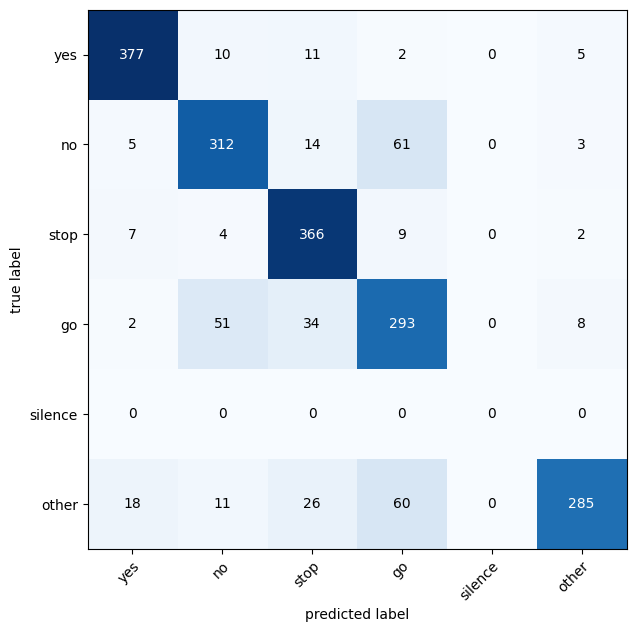

In [31]:
# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(conf_mat = confmat_tensor.numpy(), # matplotlib likes to working with numpy
                                class_names = class_names,
                                figsize = (10, 7))

# 2. DropOut 추가 / Batch Norm 추가

## 2.1 Dropout 추가 / Batch Norm 추가

### 2.1.1 Build a Model with Batch Norm / Dropout

In [35]:
# Batch Norm / Dropout 추가 버전
class CNNKeywordSpotter_v2(nn.Module):
    def __init__(self, num_classes=6):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),  # 추가

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.fc = nn.Linear(32, num_classes)

    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [36]:
model_v2 = CNNKeywordSpotter_v2(num_classes = 6)

In [37]:
# Setup Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_v2.parameters(), lr = 0.001)

### 2.1.2 Training Loop

#### 2.1.2.1 Collect Data

In [ ]:
history_v2 = {"epoch" : [],
              "train_loss" : [],
              "train_acc" : [],
              "val_loss" : [],
              "val_acc" : []}

#### 2.1.2.2 Implement

In [23]:
# Set the number of epochs
max_epochs = 100

In [24]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Early Stopping
early_stopper = EarlyStopping(patience=3, mode='max', save_path="v2_Model.pth")

# Measure time
from timeit import default_timer as Timer
v2_train_time_start = timer()

# Create a optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(max_epochs)):
    print(f"Epoch: {epoch}\n-------------")
    train_loss, train_acc = train_step(model = model_v2,
                                       data_loader = train_dataloader,
                                       loss_fn = loss_fn,
                                       optimizer = optimizer,
                                       accuracy_fn = accuracy_fn,
                                       device = device)
    val_loss, val_acc = test_step(model = model_v2,
                         data_loader = val_dataloader,
                         loss_fn = loss_fn,
                         accuracy_fn = accuracy_fn,
                         device = device)

    # Save history
    history_v2["epoch"].append(to_scalar(epoch))
    history_v2["train_loss"].append(to_scalar(train_loss))
    history_v2["train_acc"].append(to_scalar(train_acc))
    history_v2["val_loss"].append(to_scalar(val_loss))
    history_v2["val_acc"].append(to_scalar(val_acc))

    early_stopper(val_acc, model_v2)
    if early_stopper.early_stop:
        break
    
v2_train_time_end = timer()
total_train_time_model_baseline = print_train_time(start = v2_train_time_start,
                                                   end = v2_train_time_end,
                                                   device = device)

/Users/Kpiano/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0
-------------
Train loss: 1.54169 | Train acc: 38.76%


  1%|          | 1/100 [00:39<1:04:25, 39.05s/it]

Test loss: 1.43809 | Test acc : 41.39%
Saving Model to models/v2_Model.pth
Epoch: 1
-------------
Train loss: 1.28494 | Train acc: 49.59%


  2%|▏         | 2/100 [01:04<50:38, 31.00s/it]  

Test loss: 1.29535 | Test acc : 47.67%
Saving Model to models/v2_Model.pth
Epoch: 2
-------------
Train loss: 1.17679 | Train acc: 54.67%


  3%|▎         | 3/100 [01:37<51:21, 31.76s/it]

Test loss: 1.25238 | Test acc : 50.04%
Saving Model to models/v2_Model.pth
Epoch: 3
-------------
Train loss: 1.11148 | Train acc: 56.76%


  4%|▍         | 4/100 [02:06<49:27, 30.92s/it]

Test loss: 1.16036 | Test acc : 52.48%
Saving Model to models/v2_Model.pth
Epoch: 4
-------------
Train loss: 1.05842 | Train acc: 58.80%


  5%|▌         | 5/100 [02:31<45:28, 28.72s/it]

Test loss: 1.07673 | Test acc : 58.00%
Saving Model to models/v2_Model.pth
Epoch: 5
-------------
Train loss: 1.01359 | Train acc: 60.78%


  6%|▌         | 6/100 [02:57<43:18, 27.65s/it]

Test loss: 1.05582 | Test acc : 59.03%
Saving Model to models/v2_Model.pth
Epoch: 6
-------------
Train loss: 0.98618 | Train acc: 61.93%


  7%|▋         | 7/100 [03:29<45:01, 29.05s/it]

Test loss: 1.04862 | Test acc : 57.17%
Epoch: 7
-------------
Train loss: 0.95598 | Train acc: 63.14%


  8%|▊         | 8/100 [03:53<42:26, 27.68s/it]

Test loss: 0.99692 | Test acc : 60.50%
Saving Model to models/v2_Model.pth
Epoch: 8
-------------
Train loss: 0.92913 | Train acc: 64.21%


  9%|▉         | 9/100 [04:18<40:34, 26.76s/it]

Test loss: 1.00377 | Test acc : 59.97%
Epoch: 9
-------------
Train loss: 0.90584 | Train acc: 65.50%


 10%|█         | 10/100 [04:43<39:19, 26.22s/it]

Test loss: 0.95052 | Test acc : 62.89%
Saving Model to models/v2_Model.pth
Epoch: 10
-------------
Train loss: 0.88297 | Train acc: 66.43%


 11%|█         | 11/100 [05:08<38:20, 25.84s/it]

Test loss: 0.93908 | Test acc : 63.53%
Saving Model to models/v2_Model.pth
Epoch: 11
-------------
Train loss: 0.86205 | Train acc: 67.95%


 12%|█▏        | 12/100 [05:33<37:32, 25.60s/it]

Test loss: 0.90425 | Test acc : 64.84%
Saving Model to models/v2_Model.pth
Epoch: 12
-------------
Train loss: 0.84676 | Train acc: 68.27%


 13%|█▎        | 13/100 [05:58<36:58, 25.51s/it]

Test loss: 0.89205 | Test acc : 65.11%
Saving Model to models/v2_Model.pth
Epoch: 13
-------------
Train loss: 0.83017 | Train acc: 68.96%


 14%|█▍        | 14/100 [06:24<36:30, 25.48s/it]

Test loss: 0.87944 | Test acc : 65.62%
Saving Model to models/v2_Model.pth
Epoch: 14
-------------
Train loss: 0.81434 | Train acc: 70.03%


 15%|█▌        | 15/100 [06:49<35:52, 25.32s/it]

Test loss: 0.84183 | Test acc : 67.40%
Saving Model to models/v2_Model.pth
Epoch: 15
-------------
Train loss: 0.79871 | Train acc: 70.64%


 16%|█▌        | 16/100 [07:14<35:34, 25.41s/it]

Test loss: 0.83501 | Test acc : 68.64%
Saving Model to models/v2_Model.pth
Epoch: 16
-------------
Train loss: 0.78482 | Train acc: 71.31%


 17%|█▋        | 17/100 [07:40<35:21, 25.56s/it]

Test loss: 0.80662 | Test acc : 69.20%
Saving Model to models/v2_Model.pth
Epoch: 17
-------------
Train loss: 0.77193 | Train acc: 71.99%


 18%|█▊        | 18/100 [08:06<35:01, 25.62s/it]

Test loss: 0.84021 | Test acc : 68.64%
Epoch: 18
-------------
Train loss: 0.75787 | Train acc: 72.41%


 19%|█▉        | 19/100 [08:31<34:27, 25.53s/it]

Test loss: 0.81457 | Test acc : 70.58%
Saving Model to models/v2_Model.pth
Epoch: 19
-------------
Train loss: 0.74555 | Train acc: 73.12%


 20%|██        | 20/100 [08:58<34:25, 25.82s/it]

Test loss: 0.78256 | Test acc : 69.78%
Epoch: 20
-------------
Train loss: 0.73391 | Train acc: 73.45%


 21%|██        | 21/100 [09:24<34:04, 25.88s/it]

Test loss: 0.75315 | Test acc : 72.12%
Saving Model to models/v2_Model.pth
Epoch: 21
-------------
Train loss: 0.72229 | Train acc: 74.07%


 22%|██▏       | 22/100 [09:50<33:36, 25.85s/it]

Test loss: 0.75788 | Test acc : 70.41%
Epoch: 22
-------------
Train loss: 0.70668 | Train acc: 74.39%


 23%|██▎       | 23/100 [10:16<33:28, 26.09s/it]

Test loss: 0.75135 | Test acc : 72.22%
Saving Model to models/v2_Model.pth
Epoch: 23
-------------
Train loss: 0.70025 | Train acc: 74.72%


 24%|██▍       | 24/100 [10:43<33:12, 26.22s/it]

Test loss: 0.72525 | Test acc : 72.72%
Saving Model to models/v2_Model.pth
Epoch: 24
-------------
Train loss: 0.68162 | Train acc: 75.88%


 25%|██▌       | 25/100 [11:09<32:50, 26.27s/it]

Test loss: 0.70652 | Test acc : 74.74%
Saving Model to models/v2_Model.pth
Epoch: 25
-------------
Train loss: 0.67320 | Train acc: 76.50%


 26%|██▌       | 26/100 [11:36<32:31, 26.37s/it]

Test loss: 0.72773 | Test acc : 71.36%
Epoch: 26
-------------
Train loss: 0.65845 | Train acc: 76.69%


 27%|██▋       | 27/100 [12:02<32:10, 26.44s/it]

Test loss: 0.71605 | Test acc : 71.16%
Epoch: 27
-------------
Train loss: 0.65612 | Train acc: 76.64%


 27%|██▋       | 27/100 [12:29<33:47, 27.77s/it]

Test loss: 0.68754 | Test acc : 74.11%
Early stopping triggered.
Train time on cpu: 749.914 seconds


#### 2.1.2.3 Save History

In [25]:
df_history_v2 = pd.DataFrame(history_v2)
df_history_v2.to_csv("training_history_v2.csv", index=False)
print("Saved training history to training_history_v2.csv")

Saved training history to training_history_v2.csv


In [ ]:
df_history_v2

#### 2.1.2.4 Load Model

In [38]:
# Load in the save state_dict()
MODEL_PATH = Path("models")
MODEL_NAME = "v2_Model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Create a new instance
Loaded_model_v2 = CNNKeywordSpotter_v2(num_classes = 6)

# Load Model
Loaded_model_v2.load_state_dict(torch.load(f = MODEL_SAVE_PATH, map_location = 'cpu'))

<All keys matched successfully>

### 2.1.3 Evalulate Model

In [39]:
y_preds = []
y_trues = []

In [40]:
# Calculate model 0 results on test datasets
model_v2_results = eval_model(model = Loaded_model_v2,
                                    data_loader = test_dataloader,
                                    loss_fn = loss_fn,
                                    accuracy_fn = accuracy_fn)

print(model_v2_results)
# y_pred
y_pred_tensor = torch.cat(y_preds)
print(y_pred_tensor)
# y_true
y_true_tensor = torch.cat(y_trues)
print(y_true_tensor)

100%|██████████| 62/62 [00:01<00:00, 37.17it/s]

{'model_name': 'CNNKeywordSpotter_v2', 'model_loss': 0.7108920812606812, 'model_acc': 74.6975806451613}
tensor([1, 0, 3,  ..., 1, 3, 3])
tensor([1, 0, 3,  ..., 1, 2, 5])


### 2.1.4 Confusion Matrix

In [41]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(task = "MULTICLASS", num_classes = len(class_names))
confmat_tensor = confmat(preds = y_pred_tensor,
                         target = y_true_tensor)
print(confmat_tensor)

tensor([[359,  21,  15,   5,   0,   5],
        [  4, 312,  10,  66,   0,   3],
        [  3,   5, 358,  19,   0,   3],
        [  0,  61,  16, 307,   0,   4],
        [  0,   0,   0,   0,   0,   0],
        [ 22,  60,  33, 144,   0, 141]])


In [42]:
confmat_tensor = confmat_tensor.to(dtype=torch.float32).cpu()
print(confmat_tensor.dtype)
print(confmat_tensor.device)

torch.float32
cpu


In [43]:
conf_mat = confmat_tensor.numpy()

/Users/Kpiano/miniconda3/lib/python3.12/site-packages/mlxtend/plotting/plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


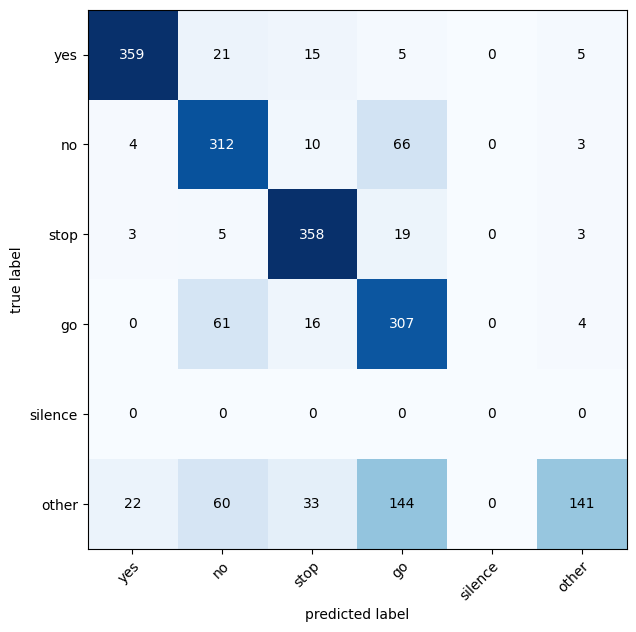

In [44]:
# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(conf_mat = confmat_tensor.numpy(), # matplotlib likes to working with numpy
                                class_names = class_names,
                                figsize = (10, 7))

결과 : 오히려 추론 능력 감소.
-> Batch Norm과 Dropout 충돌 가능성
-> Batch Norm만 추가한 버전과 Dropout만 추가한 버전 실험

## 2.2 BatchNorm만 추가

### 2.2.1 Build a Model with Batch Norm

In [1]:
# Batch Norm 추가
class CNNKeywordSpotter_v3(nn.Module):
    def __init__(self, num_classes=6):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.fc = nn.Linear(32, num_classes)

    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

NameError: name 'nn' is not defined

In [ ]:
model_v3 = CNNKeywordSpotter_v3(num_classes = 6)

In [ ]:
# Setup Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_v3.parameters(), lr = 0.001)

### 2.2.2 Training Loop

#### 2.2.2.1 Collect Data

In [ ]:
history_v3 = {"epoch" : [],
              "train_loss" : [],
              "train_acc" : [],
              "val_loss" : [],
              "val_acc" : []}

#### 2.2.2.2 Implement

In [ ]:
# Set the number of epochs
max_epochs = 100

In [ ]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Early Stopping
early_stopper = EarlyStopping(patience=3, mode='max', save_path="v3_Model.pth")

# Measure time
from timeit import default_timer as Timer
v3_train_time_start = timer()

# Create a optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(max_epochs)):
    print(f"Epoch: {epoch}\n-------------")
    train_loss, train_acc = train_step(model = model_v3,
                                       data_loader = train_dataloader,
                                       loss_fn = loss_fn,
                                       optimizer = optimizer,
                                       accuracy_fn = accuracy_fn,
                                       device = device)
    val_loss, val_acc = test_step(model = model_v3,
                         data_loader = val_dataloader,
                         loss_fn = loss_fn,
                         accuracy_fn = accuracy_fn,
                         device = device)

    # Save history
    history_v3["epoch"].append(to_scalar(epoch))
    history_v3["train_loss"].append(to_scalar(train_loss))
    history_v3["train_acc"].append(to_scalar(train_acc))
    history_v3["val_loss"].append(to_scalar(val_loss))
    history_v3["val_acc"].append(to_scalar(val_acc))

    early_stopper(val_acc, model_v3)
    if early_stopper.early_stop:
        break
    
v3_train_time_end = timer()
total_train_time_model_baseline = print_train_time(start = v3_train_time_start,
                                                   end = v3_train_time_end,
                                                   device = device)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0
-------------
Train loss: 1.48636 | Train acc: 42.97%


  1%|          | 1/100 [00:37<1:02:08, 37.66s/it]

Test loss: 1.37563 | Test acc : 48.35%
Saving Model to models/v3_Model.pth
Epoch: 1
-------------
Train loss: 1.19656 | Train acc: 54.82%


  2%|▏         | 2/100 [01:01<48:39, 29.79s/it]  

Test loss: 1.21235 | Test acc : 49.88%
Saving Model to models/v3_Model.pth
Epoch: 2
-------------
Train loss: 1.08221 | Train acc: 58.81%


  3%|▎         | 3/100 [01:30<47:26, 29.35s/it]

Test loss: 1.13736 | Test acc : 55.30%
Saving Model to models/v3_Model.pth
Epoch: 3
-------------
Train loss: 1.01366 | Train acc: 61.39%


  4%|▍         | 4/100 [01:57<45:08, 28.21s/it]

Test loss: 1.09416 | Test acc : 54.90%
Epoch: 4
-------------
Train loss: 0.96195 | Train acc: 63.46%


  5%|▌         | 5/100 [02:24<43:56, 27.75s/it]

Test loss: 1.05767 | Test acc : 58.78%
Saving Model to models/v3_Model.pth
Epoch: 5
-------------
Train loss: 0.91684 | Train acc: 65.20%


  6%|▌         | 6/100 [02:51<43:19, 27.65s/it]

Test loss: 1.15282 | Test acc : 54.35%
Epoch: 6
-------------
Train loss: 0.87945 | Train acc: 67.58%


  7%|▋         | 7/100 [03:18<42:28, 27.40s/it]

Test loss: 0.93770 | Test acc : 63.32%
Saving Model to models/v3_Model.pth
Epoch: 7
-------------
Train loss: 0.84195 | Train acc: 69.15%


  8%|▊         | 8/100 [03:45<41:55, 27.34s/it]

Test loss: 0.99776 | Test acc : 58.99%
Epoch: 8
-------------
Train loss: 0.81395 | Train acc: 70.20%


  9%|▉         | 9/100 [04:12<41:22, 27.28s/it]

Test loss: 0.92051 | Test acc : 62.39%
Epoch: 9
-------------
Train loss: 0.78572 | Train acc: 71.44%


 10%|█         | 10/100 [04:39<40:39, 27.11s/it]

Test loss: 0.89544 | Test acc : 66.65%
Saving Model to models/v3_Model.pth
Epoch: 10
-------------
Train loss: 0.76028 | Train acc: 72.77%


 11%|█         | 11/100 [05:07<40:22, 27.22s/it]

Test loss: 1.04256 | Test acc : 53.29%
Epoch: 11
-------------
Train loss: 0.73693 | Train acc: 74.02%


 12%|█▏        | 12/100 [05:34<40:02, 27.30s/it]

Test loss: 0.88829 | Test acc : 64.21%
Epoch: 12
-------------
Train loss: 0.71690 | Train acc: 74.69%


 13%|█▎        | 13/100 [06:01<39:16, 27.08s/it]

Test loss: 0.74970 | Test acc : 72.47%
Saving Model to models/v3_Model.pth
Epoch: 13
-------------
Train loss: 0.69959 | Train acc: 75.19%


 14%|█▍        | 14/100 [06:28<39:00, 27.21s/it]

Test loss: 0.76901 | Test acc : 70.41%
Epoch: 14
-------------
Train loss: 0.68010 | Train acc: 75.95%


 15%|█▌        | 15/100 [06:56<38:43, 27.33s/it]

Test loss: 0.69966 | Test acc : 75.42%
Saving Model to models/v3_Model.pth
Epoch: 15
-------------
Train loss: 0.66983 | Train acc: 76.28%


 16%|█▌        | 16/100 [07:23<38:14, 27.32s/it]

Test loss: 0.89128 | Test acc : 62.34%
Epoch: 16
-------------
Train loss: 0.64873 | Train acc: 77.28%


 17%|█▋        | 17/100 [07:50<37:37, 27.20s/it]

Test loss: 0.69752 | Test acc : 73.71%
Epoch: 17
-------------
Train loss: 0.63083 | Train acc: 77.80%


 17%|█▋        | 17/100 [08:17<40:31, 29.29s/it]

Test loss: 0.67842 | Test acc : 75.22%
Early stopping triggered.
Train time on cpu: 497.981 seconds


#### 2.2.2.3 Save History

In [ ]:
df_history_v3 = pd.DataFrame(history_v3)
df_history_v3.to_csv("training_history_v3.csv", index=False)
print("Saved training history to training_history_v3.csv")

Saved training history to training_history_v3.csv


In [ ]:
df_history_v3

,epoch,train_loss,train_acc,val_loss,val_acc
0,0,1.486360,42.968750,1.375626,48.351094
1,1,1.196562,54.816535,1.212352,49.884793
2,2,1.082207,58.811937,1.137359,55.304339
3,3,1.013663,61.387950,1.094159,54.898714
4,4,0.961953,63.457207,1.057673,58.784562
5,5,0.916844,65.200357,1.152815,54.349078
6,6,0.879445,67.579298,0.937701,63.318452
7,7,0.841951,69.148836,0.997764,58.986175
8,8,0.813954,70.202233,0.920514,62.389593
9,9,0.785720,71.436280,0.895435,66.649866


#### 2.2.2.4 Load Model

In [ ]:
# Load in the save state_dict()
MODEL_PATH = Path("models")
MODEL_NAME = "v3_Model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Create a new instance
Loaded_model_v3 = CNNKeywordSpotter_v3(num_classes = 6)

# Load Model
Loaded_model_v3.load_state_dict(torch.load(f = MODEL_SAVE_PATH, map_location = 'cpu'))

<All keys matched successfully>

### 2.2.3 Evalulate Model

In [ ]:
y_preds = []
y_trues = []

In [ ]:
# Calculate model 0 results on test datasets
model_v3_results = eval_model(model = Loaded_model_v3,
                                    data_loader = test_dataloader,
                                    loss_fn = loss_fn,
                                    accuracy_fn = accuracy_fn)

print(model_v3_results)
# y_pred
y_pred_tensor = torch.cat(y_preds)
print(y_pred_tensor)
# y_true
y_true_tensor = torch.cat(y_trues)
print(y_true_tensor)

100%|██████████| 62/62 [00:01<00:00, 35.71it/s]

{'model_name': 'CNNKeywordSpotter_v3', 'model_loss': 0.6924793124198914, 'model_acc': 75.5880376344086}
tensor([3, 1, 5,  ..., 5, 3, 5])
tensor([5, 1, 5,  ..., 5, 3, 5])


### 2.2.4 Confusion Matrix

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(task = "MULTICLASS", num_classes = len(class_names))
confmat_tensor = confmat(preds = y_pred_tensor,
                         target = y_true_tensor)
print(confmat_tensor)

tensor([[372,   6,  14,   1,   0,  12],
        [  5, 263,  10,  98,   0,  19],
        [  8,   3, 353,  16,   0,   8],
        [  5,  56,  24, 286,   0,  17],
        [  0,   0,   0,   0,   0,   0],
        [ 28,  31,  28,  93,   0, 220]])


In [ ]:
confmat_tensor = confmat_tensor.to(dtype=torch.float32).cpu()
print(confmat_tensor.dtype)
print(confmat_tensor.device)

torch.float32
cpu


In [ ]:
conf_mat = confmat_tensor.numpy()

/Users/Kpiano/miniconda3/lib/python3.12/site-packages/mlxtend/plotting/plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


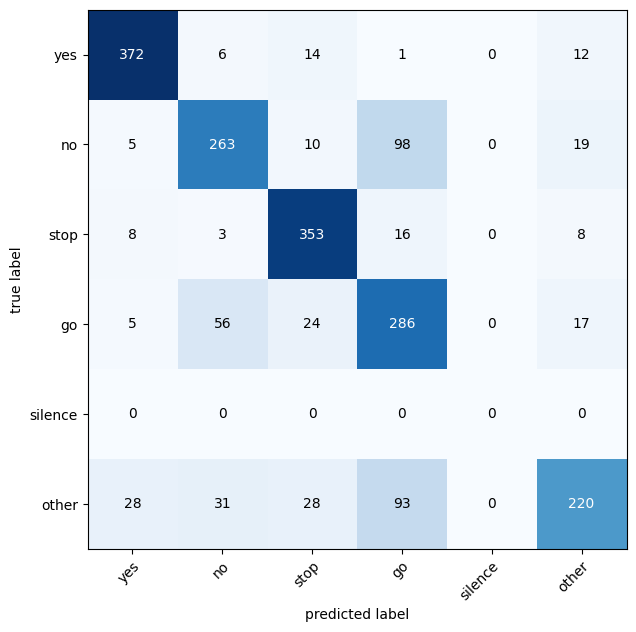

In [ ]:
# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(conf_mat = confmat_tensor.numpy(), # matplotlib likes to working with numpy
                                class_names = class_names,
                                figsize = (10, 7))

## 2.3 Dropout만 추가

### 2.3.1 Build a Model with Dropout

In [37]:
# Drop out 추가
class CNNKeywordSpotter_v4(nn.Module):
    def __init__(self, num_classes=6):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.fc = nn.Linear(32, num_classes)

    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [38]:
model_v4 = CNNKeywordSpotter_v4(num_classes = 6)

In [39]:
# Setup Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_v4.parameters(), lr = 0.001)

### 2.3.2 Training Loop

#### 2.3.2.1 Collect Data

In [39]:
history_v4 = {"epoch" : [],
              "train_loss" : [],
              "train_acc" : [],
              "val_loss" : [],
              "val_acc" : []}

#### 2.3.2.2 Implement

In [40]:
# Set the number of epochs
max_epochs = 100

In [41]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Early Stopping
early_stopper = EarlyStopping(patience=3, mode='max', save_path="v4_Model.pth")

# Measure time
from timeit import default_timer as Timer
v4_train_time_start = timer()

# Create a optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(max_epochs)):
    print(f"Epoch: {epoch}\n-------------")
    train_loss, train_acc = train_step(model = model_v4,
                                       data_loader = train_dataloader,
                                       loss_fn = loss_fn,
                                       optimizer = optimizer,
                                       accuracy_fn = accuracy_fn,
                                       device = device)
    val_loss, val_acc = test_step(model = model_v4,
                         data_loader = val_dataloader,
                         loss_fn = loss_fn,
                         accuracy_fn = accuracy_fn,
                         device = device)

    # Save history
    history_v4["epoch"].append(to_scalar(epoch))
    history_v4["train_loss"].append(to_scalar(train_loss))
    history_v4["train_acc"].append(to_scalar(train_acc))
    history_v4["val_loss"].append(to_scalar(val_loss))
    history_v4["val_acc"].append(to_scalar(val_acc))

    early_stopper(val_acc, model_v4)
    if early_stopper.early_stop:
        break
    
v4_train_time_end = timer()
total_train_time_model_baseline = print_train_time(start = v4_train_time_start,
                                                   end = v4_train_time_end,
                                                   device = device)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0
-------------
Train loss: 1.37741 | Train acc: 40.79%


  1%|          | 1/100 [00:20<33:45, 20.46s/it]

Test loss: 1.34886 | Test acc : 42.17%
Saving Model to models/v4_Model.pth
Epoch: 1
-------------
Train loss: 1.14601 | Train acc: 53.98%


  2%|▏         | 2/100 [00:39<32:02, 19.62s/it]

Test loss: 1.17208 | Test acc : 51.45%
Saving Model to models/v4_Model.pth
Epoch: 2
-------------
Train loss: 1.01306 | Train acc: 58.88%


  3%|▎         | 3/100 [01:01<33:32, 20.74s/it]

Test loss: 1.01319 | Test acc : 54.70%
Saving Model to models/v4_Model.pth
Epoch: 3
-------------
Train loss: 0.90356 | Train acc: 63.73%


  4%|▍         | 4/100 [01:27<36:23, 22.74s/it]

Test loss: 0.98239 | Test acc : 58.58%
Saving Model to models/v4_Model.pth
Epoch: 4
-------------
Train loss: 0.85564 | Train acc: 65.30%


  5%|▌         | 5/100 [01:51<36:47, 23.24s/it]

Test loss: 0.88286 | Test acc : 64.81%
Saving Model to models/v4_Model.pth
Epoch: 5
-------------
Train loss: 0.80373 | Train acc: 68.49%


  6%|▌         | 6/100 [02:14<36:15, 23.14s/it]

Test loss: 0.89074 | Test acc : 64.48%
Epoch: 6
-------------
Train loss: 0.76983 | Train acc: 69.86%


  7%|▋         | 7/100 [02:37<35:56, 23.19s/it]

Test loss: 0.88314 | Test acc : 64.53%
Epoch: 7
-------------
Train loss: 0.74263 | Train acc: 70.97%


  8%|▊         | 8/100 [03:02<36:09, 23.58s/it]

Test loss: 0.82068 | Test acc : 68.09%
Saving Model to models/v4_Model.pth
Epoch: 8
-------------
Train loss: 0.71203 | Train acc: 73.27%


  9%|▉         | 9/100 [03:25<35:52, 23.65s/it]

Test loss: 0.83200 | Test acc : 68.04%
Epoch: 9
-------------
Train loss: 0.69299 | Train acc: 73.74%


 10%|█         | 10/100 [03:49<35:30, 23.67s/it]

Test loss: 0.73040 | Test acc : 73.31%
Saving Model to models/v4_Model.pth
Epoch: 10
-------------
Train loss: 0.66852 | Train acc: 75.04%


 11%|█         | 11/100 [04:14<35:28, 23.92s/it]

Test loss: 0.73408 | Test acc : 72.90%
Epoch: 11
-------------
Train loss: 0.65048 | Train acc: 75.69%


 12%|█▏        | 12/100 [04:38<35:07, 23.95s/it]

Test loss: 0.73474 | Test acc : 70.83%
Epoch: 12
-------------
Train loss: 0.62516 | Train acc: 76.81%


 13%|█▎        | 13/100 [05:02<34:56, 24.10s/it]

Test loss: 0.66281 | Test acc : 76.15%
Saving Model to models/v4_Model.pth
Epoch: 13
-------------
Train loss: 0.60214 | Train acc: 77.98%


 14%|█▍        | 14/100 [05:27<34:41, 24.20s/it]

Test loss: 0.67200 | Test acc : 73.63%
Epoch: 14
-------------
Train loss: 0.58776 | Train acc: 78.45%


 15%|█▌        | 15/100 [05:51<34:19, 24.22s/it]

Test loss: 0.64247 | Test acc : 76.50%
Saving Model to models/v4_Model.pth
Epoch: 15
-------------
Train loss: 0.55674 | Train acc: 79.96%


 16%|█▌        | 16/100 [06:14<33:33, 23.97s/it]

Test loss: 0.62097 | Test acc : 76.66%
Saving Model to models/v4_Model.pth
Epoch: 16
-------------
Train loss: 0.54230 | Train acc: 80.57%


 17%|█▋        | 17/100 [06:38<32:57, 23.82s/it]

Test loss: 0.56890 | Test acc : 77.69%
Saving Model to models/v4_Model.pth
Epoch: 17
-------------
Train loss: 0.51495 | Train acc: 81.62%


 18%|█▊        | 18/100 [07:03<33:03, 24.19s/it]

Test loss: 0.53109 | Test acc : 81.50%
Saving Model to models/v4_Model.pth
Epoch: 18
-------------
Train loss: 0.49822 | Train acc: 81.86%


 19%|█▉        | 19/100 [07:27<32:51, 24.34s/it]

Test loss: 0.48539 | Test acc : 83.94%
Saving Model to models/v4_Model.pth
Epoch: 19
-------------
Train loss: 0.47926 | Train acc: 82.68%


 20%|██        | 20/100 [07:52<32:31, 24.39s/it]

Test loss: 0.49246 | Test acc : 84.09%
Saving Model to models/v4_Model.pth
Epoch: 20
-------------
Train loss: 0.47039 | Train acc: 82.85%


 21%|██        | 21/100 [08:17<32:11, 24.44s/it]

Test loss: 0.49357 | Test acc : 80.26%
Epoch: 21
-------------
Train loss: 0.45363 | Train acc: 83.95%


 22%|██▏       | 22/100 [08:41<31:42, 24.40s/it]

Test loss: 0.45014 | Test acc : 84.60%
Saving Model to models/v4_Model.pth
Epoch: 22
-------------
Train loss: 0.44317 | Train acc: 84.46%


 23%|██▎       | 23/100 [09:05<31:06, 24.24s/it]

Test loss: 0.44755 | Test acc : 83.31%
Epoch: 23
-------------
Train loss: 0.43398 | Train acc: 84.57%


 24%|██▍       | 24/100 [09:29<30:54, 24.40s/it]

Test loss: 0.45315 | Test acc : 82.28%
Epoch: 24
-------------
Train loss: 0.42616 | Train acc: 85.00%


 25%|██▌       | 25/100 [09:54<30:33, 24.44s/it]

Test loss: 0.42465 | Test acc : 85.51%
Saving Model to models/v4_Model.pth
Epoch: 25
-------------
Train loss: 0.40703 | Train acc: 85.67%


 26%|██▌       | 26/100 [10:18<30:07, 24.43s/it]

Test loss: 0.44685 | Test acc : 83.89%
Epoch: 26
-------------
Train loss: 0.40162 | Train acc: 85.50%


 27%|██▋       | 27/100 [10:42<29:30, 24.26s/it]

Test loss: 0.42151 | Test acc : 85.56%
Saving Model to models/v4_Model.pth
Epoch: 27
-------------
Train loss: 0.39208 | Train acc: 85.98%


 28%|██▊       | 28/100 [11:07<29:12, 24.34s/it]

Test loss: 0.44228 | Test acc : 84.32%
Epoch: 28
-------------
Train loss: 0.38527 | Train acc: 86.33%


 29%|██▉       | 29/100 [11:31<28:53, 24.41s/it]

Test loss: 0.41921 | Test acc : 86.26%
Saving Model to models/v4_Model.pth
Epoch: 29
-------------
Train loss: 0.37193 | Train acc: 86.82%


 30%|███       | 30/100 [11:55<28:18, 24.26s/it]

Test loss: 0.36914 | Test acc : 86.69%
Saving Model to models/v4_Model.pth
Epoch: 30
-------------
Train loss: 0.36889 | Train acc: 87.10%


 31%|███       | 31/100 [12:19<27:50, 24.21s/it]

Test loss: 0.36291 | Test acc : 87.12%
Saving Model to models/v4_Model.pth
Epoch: 31
-------------
Train loss: 0.36248 | Train acc: 87.40%


 32%|███▏      | 32/100 [12:45<28:02, 24.75s/it]

Test loss: 0.36128 | Test acc : 87.80%
Saving Model to models/v4_Model.pth
Epoch: 32
-------------
Train loss: 0.35618 | Train acc: 87.55%


 33%|███▎      | 33/100 [13:14<28:54, 25.88s/it]

Test loss: 0.36965 | Test acc : 86.29%
Epoch: 33
-------------
Train loss: 0.35158 | Train acc: 87.48%


 34%|███▍      | 34/100 [13:38<28:03, 25.50s/it]

Test loss: 0.34612 | Test acc : 88.33%
Saving Model to models/v4_Model.pth
Epoch: 34
-------------
Train loss: 0.34848 | Train acc: 87.79%


 35%|███▌      | 35/100 [14:04<27:28, 25.37s/it]

Test loss: 0.32513 | Test acc : 88.68%
Saving Model to models/v4_Model.pth
Epoch: 35
-------------
Train loss: 0.33637 | Train acc: 88.21%


 36%|███▌      | 36/100 [14:28<26:45, 25.09s/it]

Test loss: 0.44184 | Test acc : 83.29%
Epoch: 36
-------------
Train loss: 0.33190 | Train acc: 88.35%


 37%|███▋      | 37/100 [14:53<26:11, 24.95s/it]

Test loss: 0.36527 | Test acc : 87.50%
Epoch: 37
-------------
Train loss: 0.33547 | Train acc: 87.95%


 37%|███▋      | 37/100 [15:17<26:02, 24.80s/it]

Test loss: 0.35971 | Test acc : 87.85%
Early stopping triggered.
Train time on cpu: 917.745 seconds


#### 2.3.2.3 Save History

In [42]:
df_history_v4 = pd.DataFrame(history_v4)
df_history_v4.to_csv("training_history_v4.csv", index=False)
print("Saved training history to training_history_v4.csv")

Saved training history to training_history_v4.csv


In [43]:
df_history_v4

,epoch,train_loss,train_acc,val_loss,val_acc
0,0,1.377410,40.791573,1.348861,42.170699
1,1,1.146012,53.983671,1.172082,51.447293
2,2,1.013059,58.882320,1.013191,54.699501
3,3,0.903564,63.729354,0.982393,58.580549
4,4,0.855635,65.303585,0.882859,64.811348
5,5,0.803726,68.494276,0.890743,64.475326
6,6,0.769825,69.864396,0.883138,64.530530
7,7,0.742628,70.967061,0.820676,68.085157
8,8,0.712028,73.266235,0.831996,68.037154
9,9,0.692987,73.740146,0.730398,73.310292


#### 2.3.2.4 Load Model

In [40]:
# Load in the save state_dict()
MODEL_PATH = Path("models")
MODEL_NAME = "v4_Model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Create a new instance
Loaded_model_v4 = CNNKeywordSpotter_v4(num_classes = 6)

# Load Model
Loaded_model_v4.load_state_dict(torch.load(f = MODEL_SAVE_PATH, map_location = 'cpu'))

<All keys matched successfully>

### 2.3.3 Evaluate Model

In [323]:
y_preds = []
y_trues = []

In [324]:
# Calculate model 0 results on test datasets
model_v4_results = eval_model(model = Loaded_model_v4,
                                    data_loader = test_dataloader,
                                    loss_fn = loss_fn,
                                    accuracy_fn = accuracy_fn)

print(model_v4_results)
# y_pred
y_pred_tensor = torch.cat(y_preds)
print(y_pred_tensor)
# y_true
y_true_tensor = torch.cat(y_trues)
print(y_true_tensor)

100%|██████████| 62/62 [00:01<00:00, 38.18it/s]

{'model_name': 'CNNKeywordSpotter_v4', 'model_loss': 0.3115907311439514, 'model_acc': 89.9361559139785}
tensor([0, 3, 1,  ..., 1, 0, 5])
tensor([0, 3, 1,  ..., 1, 0, 5])


### 2.3.4 Confusion Matrix

In [325]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(task = "MULTICLASS", num_classes = len(class_names))
confmat_tensor = confmat(preds = y_pred_tensor,
                         target = y_true_tensor)
print(confmat_tensor)

tensor([[388,   8,   1,   2,   0,   6],
        [  3, 347,   2,  37,   0,   6],
        [  3,   1, 365,  15,   0,   4],
        [  1,  36,   7, 333,   0,  11],
        [  0,   0,   0,   0,   0,   0],
        [ 10,   7,  10,  29,   0, 344]])


In [65]:
confmat_tensor = confmat_tensor.to(dtype=torch.float32).cpu()
print(confmat_tensor.dtype)
print(confmat_tensor.device)

torch.float32
cpu


In [66]:
conf_mat = confmat_tensor.numpy()

/Users/Kpiano/miniconda3/lib/python3.12/site-packages/mlxtend/plotting/plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


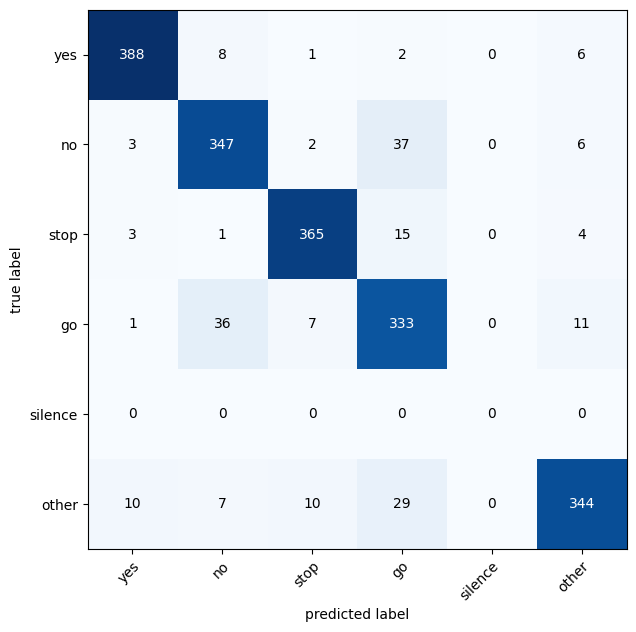

In [67]:
# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(conf_mat = confmat_tensor.numpy(), # matplotlib likes to working with numpy
                                class_names = class_names,
                                figsize = (10, 7))

## 2.4 Dropout + Light BatchNorm

### 2.4.1 Build a Model with Dropout + LightBatchNorm

In [68]:
# Batch Norm 추가
class CNNKeywordSpotter_v5(nn.Module):
    def __init__(self, num_classes=6):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16), # Conv1만 BatchNorm 추가
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.fc = nn.Linear(32, num_classes)

    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [69]:
model_v5 = CNNKeywordSpotter_v5(num_classes = 6)

In [70]:
# Setup Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_v5.parameters(), lr = 0.001)

### 2.4.2 Training Loop

#### 2.4.2.1 Collect Data

In [58]:
history_v5 = {"epoch" : [],
              "train_loss" : [],
              "train_acc" : [],
              "val_loss" : [],
              "val_acc" : []}

#### 2.4.2.2 Implement

In [59]:
# Set the number of epochs
max_epochs = 100

In [61]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Early Stopping
early_stopper = EarlyStopping(patience=3, mode='max', save_path="v5_Model.pth")

# Measure time
from timeit import default_timer as Timer
v5_train_time_start = timer()

# Create a optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(max_epochs)):
    print(f"Epoch: {epoch}\n-------------")
    train_loss, train_acc = train_step(model = model_v5,
                                       data_loader = train_dataloader,
                                       loss_fn = loss_fn,
                                       optimizer = optimizer,
                                       accuracy_fn = accuracy_fn,
                                       device = device)
    val_loss, val_acc = test_step(model = model_v5,
                         data_loader = val_dataloader,
                         loss_fn = loss_fn,
                         accuracy_fn = accuracy_fn,
                         device = device)

    # Save history
    history_v5["epoch"].append(to_scalar(epoch))
    history_v5["train_loss"].append(to_scalar(train_loss))
    history_v5["train_acc"].append(to_scalar(train_acc))
    history_v5["val_loss"].append(to_scalar(val_loss))
    history_v5["val_acc"].append(to_scalar(val_acc))

    early_stopper(val_acc, model_v5)
    if early_stopper.early_stop:
        break
    
v5_train_time_end = timer()
total_train_time_model_baseline = print_train_time(start = v5_train_time_start,
                                                   end = v5_train_time_end,
                                                   device = device)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0
-------------
Train loss: 1.35941 | Train acc: 43.06%


  1%|          | 1/100 [00:21<36:04, 21.86s/it]

Test loss: 1.35845 | Test acc : 45.09%
Saving Model to models/v5_Model.pth
Epoch: 1
-------------
Train loss: 1.22859 | Train acc: 50.60%


  2%|▏         | 2/100 [00:44<36:49, 22.54s/it]

Test loss: 1.25827 | Test acc : 48.17%
Saving Model to models/v5_Model.pth
Epoch: 2
-------------
Train loss: 1.16320 | Train acc: 53.53%


  3%|▎         | 3/100 [01:07<36:51, 22.80s/it]

Test loss: 1.23395 | Test acc : 49.91%
Saving Model to models/v5_Model.pth
Epoch: 3
-------------
Train loss: 1.12164 | Train acc: 55.36%


  4%|▍         | 4/100 [01:30<36:35, 22.87s/it]

Test loss: 1.18589 | Test acc : 50.66%
Saving Model to models/v5_Model.pth
Epoch: 4
-------------
Train loss: 1.08659 | Train acc: 56.41%


  5%|▌         | 5/100 [01:55<36:53, 23.30s/it]

Test loss: 1.19035 | Test acc : 50.90%
Saving Model to models/v5_Model.pth
Epoch: 5
-------------
Train loss: 1.06311 | Train acc: 57.47%


  6%|▌         | 6/100 [02:17<36:08, 23.07s/it]

Test loss: 1.13667 | Test acc : 53.47%
Saving Model to models/v5_Model.pth
Epoch: 6
-------------
Train loss: 1.04257 | Train acc: 57.87%


  7%|▋         | 7/100 [02:41<35:58, 23.20s/it]

Test loss: 1.09896 | Test acc : 55.36%
Saving Model to models/v5_Model.pth
Epoch: 7
-------------
Train loss: 1.02486 | Train acc: 58.53%


  8%|▊         | 8/100 [03:05<36:10, 23.59s/it]

Test loss: 1.12554 | Test acc : 53.64%
Epoch: 8
-------------
Train loss: 1.00414 | Train acc: 59.94%


  9%|▉         | 9/100 [03:29<35:52, 23.65s/it]

Test loss: 1.10921 | Test acc : 54.95%
Epoch: 9
-------------
Train loss: 0.98932 | Train acc: 60.06%


  9%|▉         | 9/100 [03:53<39:23, 25.97s/it]

Test loss: 1.06454 | Test acc : 55.21%
Early stopping triggered.
Train time on cpu: 233.776 seconds


#### 2.4.2.3 Save History

In [62]:
df_history_v5 = pd.DataFrame(history_v5)
df_history_v5.to_csv("training_history_v5.csv", index=False)
print("Saved training history to training_history_v5.csv")

Saved training history to training_history_v5.csv


In [63]:
df_history_v5

,epoch,train_loss,train_acc,val_loss,val_acc
0,0,1.359406,43.055556,1.358453,45.091686
1,1,1.228594,50.598255,1.258267,48.173483
2,2,1.163200,53.530875,1.233953,49.911194
3,3,1.121639,55.356137,1.185892,50.664843
4,4,1.086586,56.411881,1.190352,50.895257
5,5,1.063109,57.469970,1.136671,53.470622
6,6,1.042566,57.871152,1.098961,55.361943
7,7,1.024855,58.532752,1.125536,53.638633
8,8,1.004136,59.940409,1.109211,54.949117
9,9,0.989320,60.057714,1.064541,55.205933


#### 2.4.2.4 Load Model

In [72]:
# Load in the save state_dict()
MODEL_PATH = Path("models")
MODEL_NAME = "v5_Model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Create a new instance
Loaded_model_v5 = CNNKeywordSpotter_v5(num_classes = 6)

# Load Model
Loaded_model_v5.load_state_dict(torch.load(f = MODEL_SAVE_PATH, map_location = 'cpu'))

<All keys matched successfully>

### 2.4.3 Evalulate Model

In [73]:
y_preds = []
y_trues = []

In [74]:
# Calculate model 0 results on test datasets
model_v5_results = eval_model(model = Loaded_model_v5,
                                    data_loader = test_dataloader,
                                    loss_fn = loss_fn,
                                    accuracy_fn = accuracy_fn)

print(model_v5_results)
# y_pred
y_pred_tensor = torch.cat(y_preds)
print(y_pred_tensor)
# y_true
y_true_tensor = torch.cat(y_trues)
print(y_true_tensor)

100%|██████████| 62/62 [00:01<00:00, 36.10it/s]

{'model_name': 'CNNKeywordSpotter_v5', 'model_loss': 1.1158703565597534, 'model_acc': 54.82190860215054}
tensor([3, 1, 0,  ..., 3, 2, 3])
tensor([3, 3, 2,  ..., 1, 2, 1])


### 2.4.4 Confusion Matrix

In [75]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(task = "MULTICLASS", num_classes = len(class_names))
confmat_tensor = confmat(preds = y_pred_tensor,
                         target = y_true_tensor)
print(confmat_tensor)

tensor([[311,  42,  21,  18,   0,  13],
        [ 21, 279,  10,  75,   0,  10],
        [ 35,  21, 305,  27,   0,   0],
        [ 17, 197,  27, 141,   0,   6],
        [  0,   0,   0,   0,   0,   0],
        [ 86, 170,  21,  76,   0,  47]])


In [76]:
confmat_tensor = confmat_tensor.to(dtype=torch.float32).cpu()
print(confmat_tensor.dtype)
print(confmat_tensor.device)

torch.float32
cpu


In [77]:
conf_mat = confmat_tensor.numpy()

/Users/Kpiano/miniconda3/lib/python3.12/site-packages/mlxtend/plotting/plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


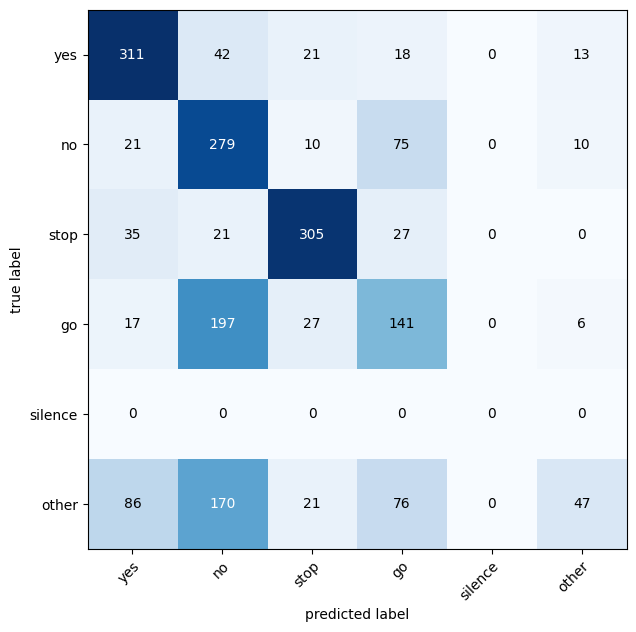

In [78]:
# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(conf_mat = confmat_tensor.numpy(), # matplotlib likes to working with numpy
                                class_names = class_names,
                                figsize = (10, 7))

-> Drop out only 구조로 확정

# 3. Quantized Model

## 3.0 Direction

지금 정확도가 높고, 구조가 안정된 상태니까

✅ “Post-training Quantization을 먼저 해보고” →

📉 정확도 손실이 크면 → 그때 n_mfcc 등 입력 튜닝으로 가는 게 더 효율적이야.

 Dropout-only 모델 → torch.quantization.quantize_dynamic() 적용

 테스트 정확도 비교

 모델 크기 .pt 비교

 ONNX 변환 & 추론 시간 측정까지 확장 가능

## 3.1 Post- Training Quantization

### 3.1.1 Make Quantized Model

In [16]:
import torch.quantization
import torch
torch.backends.quantized.engine = 'fbgemm'

In [17]:
class CNNKeywordSpotter_PTQ(nn.Module):
    def __init__(self, num_classes=6):
        super().__init__()
        self.quant = torch.quantization.QuantStub()

        self.conv_relu1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2)
        self.drop1 = nn.Dropout(0.3)

        self.conv_relu2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.pool2 = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Linear(32, num_classes)
        self.dequant = torch.quantization.DeQuantStub()

    def forward(self, x):
        x = self.quant(x)

        x = self.conv_relu1(x)
        x = self.pool1(x)
        x = self.drop1(x)

        x = self.conv_relu2(x)
        x = self.pool2(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)

        x = self.dequant(x)
        return x


In [18]:
# Create a new instance
model_fp32 = CNNKeywordSpotter_PTQ(num_classes = 6)

In [19]:
model_fp32.eval()
torch.quantization.fuse_modules(
    model_fp32,
    [['conv_relu1.0', 'conv_relu1.1'],
     ['conv_relu2.0', 'conv_relu2.1']],
     inplace = True)

CNNKeywordSpotter_PTQ(
  (quant): QuantStub()
  (conv_relu1): Sequential(
    (0): ConvReLU2d(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (1): Identity()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.3, inplace=False)
  (conv_relu2): Sequential(
    (0): ConvReLU2d(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (1): Identity()
  )
  (pool2): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=32, out_features=6, bias=True)
  (dequant): DeQuantStub()
)

In [20]:
model_fp32.state_dict().keys()

odict_keys(['conv_relu1.0.0.weight', 'conv_relu1.0.0.bias', 'conv_relu2.0.0.weight', 'conv_relu2.0.0.bias', 'fc.weight', 'fc.bias'])

In [21]:
# Load in the save state_dict()
MODEL_PATH = Path("models")
MODEL_NAME = "v4_Model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Load Model
old_state_dict = torch.load(f = MODEL_SAVE_PATH, map_location = 'cpu')
new_state_dict = {}

In [22]:
key_map = {
    "cnn.0.weight": "conv_relu1.0.0.weight",
    "cnn.0.bias":   "conv_relu1.0.0.bias",
    "cnn.4.weight": "conv_relu2.0.0.weight",
    "cnn.4.bias":   "conv_relu2.0.0.bias",
    "fc.weight":    "fc.weight",
    "fc.bias":      "fc.bias"
}

for old_key, new_key in key_map.items():
    if old_key in old_state_dict:
        new_state_dict[new_key] = old_state_dict[old_key]
    else:
        print(f"[WARNING] Key not found: {old_key}")

model_fp32.load_state_dict(new_state_dict, strict=False)

<All keys matched successfully>

In [23]:
model_fp32.qconfig = torch.quantization.get_default_qconfig('fbgemm')

In [24]:
model_prepared = torch.quantization.prepare(model_fp32)

c:\Users\Minseo\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\ao\quantization\observer.py:244: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


In [25]:
model_prepared.eval()
with torch.no_grad():
    for X_calib, _ in train_dataloader:  # calibration 용 dataloader (한 100~200개면 충분)
        model_prepared(X_calib)

In [26]:
model_int8 = torch.quantization.convert(model_prepared)

In [27]:
print(model_int8.state_dict().keys())

odict_keys(['quant.scale', 'quant.zero_point', 'conv_relu1.0.weight', 'conv_relu1.0.bias', 'conv_relu1.0.scale', 'conv_relu1.0.zero_point', 'conv_relu2.0.weight', 'conv_relu2.0.bias', 'conv_relu2.0.scale', 'conv_relu2.0.zero_point', 'fc.scale', 'fc.zero_point', 'fc._packed_params.dtype', 'fc._packed_params._packed_params'])


### 3.1.2 Evaluate Model

In [28]:
y_preds = []
y_trues = []

In [29]:
import torch
print(torch.backends.quantized.supported_engines)

['none', 'onednn', 'x86', 'fbgemm']


In [31]:
loss_fn = nn.CrossEntropyLoss()

In [32]:
# Calculate model 0 results on test datasets
model_PTQ_results = eval_model(model = model_int8,
                                    data_loader = test_dataloader,
                                    loss_fn = loss_fn,
                                    accuracy_fn = accuracy_fn)

print(model_PTQ_results)
# y_pred
y_pred_tensor = torch.cat(y_preds)
print(y_pred_tensor)
# y_true
y_true_tensor = torch.cat(y_trues)
print(y_true_tensor)

100%|██████████| 62/62 [00:25<00:00,  2.41it/s]

{'model_name': 'CNNKeywordSpotter_PTQ', 'model_loss': 1.1802372932434082, 'model_acc': 59.96303763440861}
tensor([5, 0, 5,  ..., 1, 1, 3])
tensor([5, 3, 3,  ..., 3, 1, 5])


### 3.1.3 Confusion Matrix

In [33]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(task = "MULTICLASS", num_classes = len(class_names))
confmat_tensor = confmat(preds = y_pred_tensor,
                         target = y_true_tensor)
print(confmat_tensor)

NameError: name 'class_names' is not defined

In [351]:
confmat_tensor = confmat_tensor.to(dtype=torch.float32).cpu()
print(confmat_tensor.dtype)
print(confmat_tensor.device)

torch.float32
cpu


In [352]:
conf_mat = confmat_tensor.numpy()

/Users/Kpiano/miniconda3/lib/python3.12/site-packages/mlxtend/plotting/plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


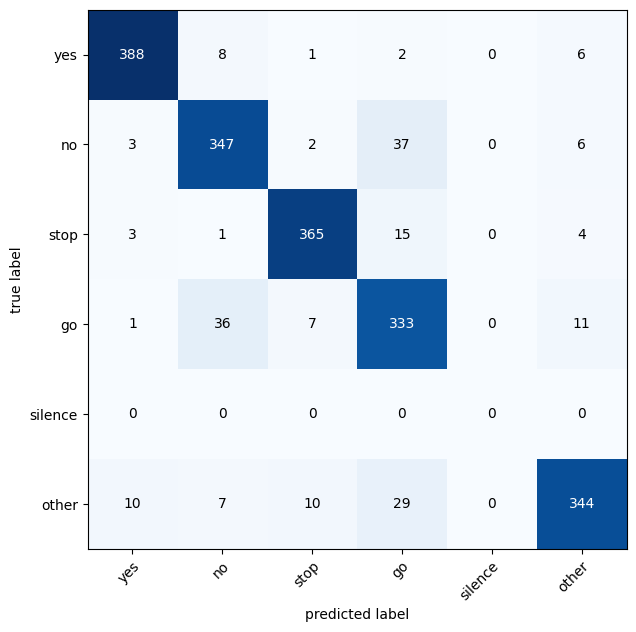

In [353]:
# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(conf_mat = confmat_tensor.numpy(), # matplotlib likes to working with numpy
                                class_names = class_names,
                                figsize = (10, 7))

## 3.2 Quantization-Aware Training

### 3.2.1 Build a Model with QAT

In [8]:
from torch.autograd.function import InplaceFunction
import torch.nn.functional as F

In [9]:
# min_value과 max_value(-2^(8-1) ~ 2^(8-1)-1)를 넘어가는 값을 자른다.
def clip(input, qbit):
    max_value = 2.**(qbit-1) - 1
    min_value = -2.**(qbit-1)
    output = torch.clamp(input = input, min = min_value, max = max_value)
    return output

In [10]:
class UniformQuantize(InplaceFunction):
    @classmethod
    def forward(cls, ctx, input, qbit):
        qmax = 2.**(qbit-1) - 1
        scale = torch.max(torch.abs(input)).item() / qmax
        scale = max(scale, 1e-8)
        output = clip(torch.round(input / scale), qbit)
        output.mul_(scale)
        return output
    @staticmethod
    def backward(ctx, grad_output):
        grad_input = grad_output
        return grad_input, None

In [11]:
def quant_minmax(input, qbit):
  return UniformQuantize().apply(input, qbit)

In [12]:
class MinMaxTracker:
    def __init__(self, momentum=0.99):
        self.min_val = None
        self.max_val = None
        self.momentum = momentum

    def update(self, x):
        batch_min = x.min().item()
        batch_max = x.max().item()
        if self.min_val is None:
            self.min_val = batch_min
            self.max_val = batch_max
        else:
            self.min_val = self.momentum * self.min_val + (1 - self.momentum) * batch_min
            self.max_val = self.momentum * self.max_val + (1 - self.momentum) * batch_max

    def get(self):
        return self.min_val, self.max_val

In [13]:
class QLinear(nn.Linear):
  def __init__(self, in_features, out_features, bias = True, quantize = True, bita = 8, bitw = 8):
    super().__init__(in_features, out_features, bias = bias)
    self.in_features = in_features
    self.out_features = out_features
    self._bias = bias
    self.quantize = quantize
    self.bita = bita
    self.bitw = bitw
    self.input_tracker = MinMaxTracker(momentum = 0.95)
    self.register_buffer("scale_i", torch.tensor(0.0))
    self.register_buffer("scale_w", torch.tensor(0.0))
    self.register_buffer("bias_q", torch.zeros_like(self.bias.data))
    self.register_buffer("weight_q", torch.zeros_like(self.weight.data))

  def freeze(self):
    # 1. input scale 계산
    x_min, x_max = self.input_tracker.get()
    max_input = max(abs(x_min), abs(x_max))
    self.scale_i.copy_(torch.tensor(max_input / (2**(self.bita-1) - 1)))

    # 2. weight scale 계산
    max_weight = torch.max(torch.abs(self.weight.data)).item()
    self.scale_w.copy_(torch.tensor(max_weight / (2**(self.bitw - 1) - 1)))

    # 3. weight 양자화
    self.weight_q.copy_(torch.round(self.weight.data / self.scale_w))

    # 4. bias 양자화
    if self.bias is not None:
      self.bias_q.copy_(torch.round(self.bias.data / (self.scale_i * self.scale_w)))

  def forward(self, input):
    if self.quantize:
      # 매번 update (훈련 중)
      if self.training:
        self.input_tracker.update(input)
        # 훈련 중일 때 Fake Quantization 적용
        Qinput = quant_minmax(input, qbit = self.bita)
        Qweight = quant_minmax(self.weight, qbit = self.bitw)
        bias = self.bias
      else:
        # 추론 시에는 고정된 scale로 양자화
        Qinput = torch.round(input / self.scale_i)
        Qweight = torch.round(self.weight / self.scale_w)
        bias = self.bias_q if self.bias is not None else None
      # Fully connected Layer  
      y = F.linear(Qinput, Qweight, bias)

      # Dequantization
      if not self.training:
        y = y * (self.scale_i * self.scale_w)

      return y
    else:
      return F.linear(input, self.weight, self.bias if self._bias else None)

In [14]:
class QConv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, quantize = True, bita = 8, bitw = 8, **kwargs):
        super().__init__(in_channels, out_channels, kernel_size, **kwargs)
        self.quantize = quantize
        self.bita = bita
        self.bitw = bitw
        self.input_tracker = MinMaxTracker(momentum = 0.95)
        self.register_buffer("scale_i", torch.tensor(0.0))
        self.register_buffer("scale_w", torch.tensor(0.0))
        self.register_buffer("bias_q", torch.zeros_like(self.bias.data))
        self.register_buffer("weight_q", torch.zeros_like(self.weight.data))

    def freeze(self):
        # 1. input scale (symmetric)
        x_min, x_max = self.input_tracker.get()
        max_input = max(abs(x_min), abs(x_max))
        self.scale_i.copy_(torch.tensor(max_input / (2**(self.bita-1) - 1)))

        # 2. weight scale (symmetric)
        max_weight = torch.max(torch.abs(self.weight.data)).item()
        self.scale_w.copy_(torch.tensor(max_weight / (2**(self.bitw - 1) - 1)))

        # 3. weight quantization
        self.weight_q.copy_(torch.round(self.weight.data / self.scale_w))

        # 4. bias quantization
        if self.bias is not None:
            self.bias_q.copy_(torch.round(self.bias.data / (self.scale_i * self.scale_w)))

    def forward(self, input):
        if self.quantize:
            if self.training:
                self.input_tracker.update(input)
                Qinput = quant_minmax(input, qbit=self.bita)
                Qweight = quant_minmax(self.weight, qbit=self.bitw)
                bias = self.bias
            else:
                Qinput = torch.round(input / self.scale_i)
                Qweight = torch.round(self.weight / self.scale_w)
                bias = self.bias_q if self.bias is not None else None
            
            y = F.conv2d(Qinput, Qweight, bias, stride = self.stride, padding = self.padding, dilation = self.dilation, groups = self.groups)

            # Dequantization
            if not self.training:
                y = y * (self.scale_i * self.scale_w)

            return y
        else:
            return F.conv2d(input, self.weight, self.bias, stride = self.stride, padding = self.padding, dilation = self.dilation, groups = self.groups)

In [15]:
class CNNKeywordSpotter_QAT(nn.Module):
    def __init__(self, num_classes=6):
        super().__init__()
        self.cnn = nn.Sequential(
            QConv2d(in_channels = 1, out_channels = 16, kernel_size = 3, quantize = True, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),

            QConv2d(in_channels = 16, out_channels = 32, kernel_size = 3, quantize = True, padding = 1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
        )

        # 여기를 QLinear로 교체!
        self.fc = QLinear(in_features = 32, out_features = num_classes, quantize = True, bita = 8, bitw = 8)

    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [16]:
model_QAT = CNNKeywordSpotter_QAT(num_classes = 6)

In [17]:
# Setup Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_QAT.parameters(), lr = 0.001)

### 3.2.2 Training Loop

#### 3.2.2.1 Collect Data

In [89]:
history_QAT = {"epoch" : [],
              "train_loss" : [],
              "train_acc" : [],
              "val_loss" : [],
              "val_acc" : []}

#### 3.2.2.2 Implement

In [90]:
# Set the number of epochs
max_epochs = 100

In [91]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Early Stopping
early_stopper = EarlyStopping(patience=3, mode='max', save_path="QAT_Model_float.pth")

# Measure time
from timeit import default_timer as Timer
QAT_train_time_start = timer()

# Create a optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(max_epochs)):
    print(f"Epoch: {epoch}\n-------------")
    train_loss, train_acc = train_step(model = model_QAT,
                                       data_loader = train_dataloader,
                                       loss_fn = loss_fn,
                                       optimizer = optimizer,
                                       accuracy_fn = accuracy_fn,
                                       device = device)
    
    # QLinear, QConv2d를 freeze로
    for module in model_QAT.modules():
        if hasattr(module, "freeze"):
            module.freeze()
            
    val_loss, val_acc = test_step(model = model_QAT,
                         data_loader = val_dataloader,
                         loss_fn = loss_fn,
                         accuracy_fn = accuracy_fn,
                         device = device)

    # Save history
    history_QAT["epoch"].append(to_scalar(epoch))
    history_QAT["train_loss"].append(to_scalar(train_loss))
    history_QAT["train_acc"].append(to_scalar(train_acc))
    history_QAT["val_loss"].append(to_scalar(val_loss))
    history_QAT["val_acc"].append(to_scalar(val_acc))

    early_stopper(val_acc, model_QAT)
    if early_stopper.early_stop:
        break
    
QAT_train_time_end = timer()
total_train_time_model_baseline = print_train_time(start = QAT_train_time_start,
                                                   end = QAT_train_time_end,
                                                   device = device)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0
-------------
Train loss: 1.38617 | Train acc: 40.84%


  1%|          | 1/100 [00:20<33:33, 20.34s/it]

Test loss: 1.33997 | Test acc : 41.49%
Saving Model to models/QAT_Model_float.pth
Epoch: 1
-------------
Train loss: 1.13716 | Train acc: 54.14%


  2%|▏         | 2/100 [00:40<33:14, 20.35s/it]

Test loss: 1.09962 | Test acc : 55.92%
Saving Model to models/QAT_Model_float.pth
Epoch: 2
-------------
Train loss: 1.00206 | Train acc: 59.74%


  3%|▎         | 3/100 [01:02<33:44, 20.87s/it]

Test loss: 1.01368 | Test acc : 56.16%
Saving Model to models/QAT_Model_float.pth
Epoch: 3
-------------
Train loss: 0.92871 | Train acc: 63.06%


  4%|▍         | 4/100 [01:24<34:11, 21.37s/it]

Test loss: 0.96483 | Test acc : 60.55%
Saving Model to models/QAT_Model_float.pth
Epoch: 4
-------------
Train loss: 0.85556 | Train acc: 66.98%


  5%|▌         | 5/100 [01:46<34:16, 21.65s/it]

Test loss: 0.92926 | Test acc : 63.37%
Saving Model to models/QAT_Model_float.pth
Epoch: 5
-------------
Train loss: 0.81042 | Train acc: 69.22%


  6%|▌         | 6/100 [02:08<34:02, 21.73s/it]

Test loss: 0.83932 | Test acc : 68.94%
Saving Model to models/QAT_Model_float.pth
Epoch: 6
-------------
Train loss: 0.75938 | Train acc: 71.83%


  7%|▋         | 7/100 [02:30<33:39, 21.72s/it]

Test loss: 0.83314 | Test acc : 68.67%
Epoch: 7
-------------
Train loss: 0.71773 | Train acc: 73.86%


  8%|▊         | 8/100 [02:53<34:13, 22.32s/it]

Test loss: 0.79893 | Test acc : 71.99%
Saving Model to models/QAT_Model_float.pth
Epoch: 8
-------------
Train loss: 0.68357 | Train acc: 75.27%


  9%|▉         | 9/100 [03:17<34:25, 22.70s/it]

Test loss: 0.71978 | Test acc : 75.65%
Saving Model to models/QAT_Model_float.pth
Epoch: 9
-------------
Train loss: 0.63485 | Train acc: 77.39%


 10%|█         | 10/100 [03:40<34:14, 22.83s/it]

Test loss: 0.71914 | Test acc : 75.30%
Epoch: 10
-------------
Train loss: 0.60496 | Train acc: 78.54%


 11%|█         | 11/100 [04:03<34:00, 22.93s/it]

Test loss: 0.66572 | Test acc : 77.36%
Saving Model to models/QAT_Model_float.pth
Epoch: 11
-------------
Train loss: 0.57270 | Train acc: 79.74%


 12%|█▏        | 12/100 [04:27<34:13, 23.34s/it]

Test loss: 0.64485 | Test acc : 75.92%
Epoch: 12
-------------
Train loss: 0.55985 | Train acc: 79.95%


 13%|█▎        | 13/100 [04:51<33:59, 23.44s/it]

Test loss: 0.59834 | Test acc : 78.42%
Saving Model to models/QAT_Model_float.pth
Epoch: 13
-------------
Train loss: 0.52561 | Train acc: 81.37%


 14%|█▍        | 14/100 [05:15<33:41, 23.50s/it]

Test loss: 0.57755 | Test acc : 80.89%
Saving Model to models/QAT_Model_float.pth
Epoch: 14
-------------
Train loss: 0.50667 | Train acc: 82.52%


 15%|█▌        | 15/100 [05:38<33:23, 23.57s/it]

Test loss: 0.53955 | Test acc : 81.72%
Saving Model to models/QAT_Model_float.pth
Epoch: 15
-------------
Train loss: 0.48281 | Train acc: 83.19%


 16%|█▌        | 16/100 [06:03<33:27, 23.90s/it]

Test loss: 0.55419 | Test acc : 81.22%
Epoch: 16
-------------
Train loss: 0.46805 | Train acc: 83.46%


 17%|█▋        | 17/100 [06:27<33:07, 23.94s/it]

Test loss: 0.54874 | Test acc : 80.49%
Epoch: 17
-------------
Train loss: 0.45616 | Train acc: 83.70%


 18%|█▊        | 18/100 [06:51<32:42, 23.93s/it]

Test loss: 0.45634 | Test acc : 84.82%
Saving Model to models/QAT_Model_float.pth
Epoch: 18
-------------
Train loss: 0.43348 | Train acc: 84.85%


 19%|█▉        | 19/100 [07:15<32:31, 24.10s/it]

Test loss: 0.43327 | Test acc : 86.14%
Saving Model to models/QAT_Model_float.pth
Epoch: 19
-------------
Train loss: 0.42759 | Train acc: 84.90%


 20%|██        | 20/100 [07:40<32:14, 24.19s/it]

Test loss: 0.43853 | Test acc : 85.48%
Epoch: 20
-------------
Train loss: 0.41262 | Train acc: 85.57%


 21%|██        | 21/100 [08:05<32:19, 24.55s/it]

Test loss: 0.41715 | Test acc : 86.59%
Saving Model to models/QAT_Model_float.pth
Epoch: 21
-------------
Train loss: 0.40525 | Train acc: 86.01%


 22%|██▏       | 22/100 [08:30<32:01, 24.63s/it]

Test loss: 0.42119 | Test acc : 86.04%
Epoch: 22
-------------
Train loss: 0.40545 | Train acc: 85.79%


 23%|██▎       | 23/100 [08:54<31:30, 24.56s/it]

Test loss: 0.42369 | Test acc : 85.71%
Epoch: 23
-------------
Train loss: 0.38400 | Train acc: 86.12%


 23%|██▎       | 23/100 [09:19<31:14, 24.35s/it]

Test loss: 0.44085 | Test acc : 84.65%
Early stopping triggered.
Train time on cpu: 559.964 seconds


#### 3.2.2.3 Save History

In [92]:
df_history_QAT = pd.DataFrame(history_QAT)
df_history_QAT.to_csv("training_history_QAT.csv", index = False)
print("Saved training history to training_history_QAT.csv")

Saved training history to training_history_QAT.csv


In [93]:
df_history_QAT

,epoch,train_loss,train_acc,val_loss,val_acc
0,0,1.386172,40.838495,1.339967,41.491455
1,1,1.137165,54.136167,1.099617,55.916379
2,2,1.002058,59.738645,1.013681,56.163594
3,3,0.928713,63.060717,0.964834,60.551075
4,4,0.855556,66.976351,0.929262,63.371256
5,5,0.810418,69.219219,0.839322,68.944412
6,6,0.759381,71.828078,0.833144,68.665995
7,7,0.717733,73.857451,0.798928,71.987807
8,8,0.683572,75.267455,0.719778,75.648041
9,9,0.634854,77.393018,0.719143,75.295219


#### 3.2.2.4 Load Model

In [18]:
# Load in the save state_dict()
MODEL_PATH = Path("models")
MODEL_NAME = "QAT_Model_float.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Create a new instance
Loaded_model_QAT_float = CNNKeywordSpotter_QAT(num_classes = 6)

# Load Model
Loaded_model_QAT_float.load_state_dict(torch.load(f = MODEL_SAVE_PATH, map_location = 'cpu'))

<All keys matched successfully>

In [19]:
qat_state = {
    "conv1": {
        "weight_q": Loaded_model_QAT_float.cnn[0].weight_q.char(), 
        "bias_q": Loaded_model_QAT_float.cnn[0].bias_q.int() if Loaded_model_QAT_float.cnn[0].bias_q is not None else None,
        "scale_i": Loaded_model_QAT_float.cnn[0].scale_i,
        "scale_w": Loaded_model_QAT_float.cnn[0].scale_w,
    },
    "conv2": {
        "weight_q": Loaded_model_QAT_float.cnn[4].weight_q.char(),
        "bias_q": Loaded_model_QAT_float.cnn[4].bias_q.int() if Loaded_model_QAT_float.cnn[4].bias_q is not None else None,
        "scale_i": Loaded_model_QAT_float.cnn[4].scale_i,
        "scale_w": Loaded_model_QAT_float.cnn[4].scale_w,
    },
    "fc": {
        "weight_q": Loaded_model_QAT_float.fc.weight_q.char(), 
        "bias_q": Loaded_model_QAT_float.fc.bias_q.int() if Loaded_model_QAT_float.fc.bias_q is not None else None, 
        "scale_i": Loaded_model_QAT_float.fc.scale_i,
        "scale_w": Loaded_model_QAT_float.fc.scale_w,
    }
}

In [96]:
torch.save(qat_state, f = Path("models") / "QAT_Model_int8.pth")
print(f"Saving Model to {"QAT_Model_int8.pth"}")

Saving Model to QAT_Model_int8.pth


In [97]:
# Load in the save state_dict()
MODEL_PATH = Path("models")
MODEL_NAME = "QAT_Model_int8.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Load State
qat_state_loaded = torch.load(f = MODEL_SAVE_PATH, map_location = 'cpu')

In [99]:
# Create a new instance
Loaded_model_QAT_int8 = CNNKeywordSpotter_QAT(num_classes = 6)

In [100]:
# conv1
Loaded_model_QAT_int8.cnn[0].weight_q = qat_state_loaded["conv1"]["weight_q"]
Loaded_model_QAT_int8.cnn[0].bias_q = qat_state_loaded["conv1"]["bias_q"]
Loaded_model_QAT_int8.cnn[0].scale_i = qat_state_loaded["conv1"]["scale_i"]
Loaded_model_QAT_int8.cnn[0].scale_w = qat_state_loaded["conv1"]["scale_w"]

# conv2
Loaded_model_QAT_int8.cnn[4].weight_q = qat_state_loaded["conv2"]["weight_q"]
Loaded_model_QAT_int8.cnn[4].bias_q = qat_state_loaded["conv2"]["bias_q"]
Loaded_model_QAT_int8.cnn[4].scale_i = qat_state_loaded["conv2"]["scale_i"]
Loaded_model_QAT_int8.cnn[4].scale_w = qat_state_loaded["conv2"]["scale_w"]

# fc
Loaded_model_QAT_int8.fc.weight_q = qat_state_loaded["fc"]["weight_q"]
Loaded_model_QAT_int8.fc.bias_q = qat_state_loaded["fc"]["bias_q"]
Loaded_model_QAT_int8.fc.scale_i = qat_state_loaded["fc"]["scale_i"]
Loaded_model_QAT_int8.fc.scale_w = qat_state_loaded["fc"]["scale_w"]


### 3.2.3 Evaluate Model

In [102]:
y_preds = []
y_trues = []

In [103]:
# Calculate model 0 results on test datasets
model_QAT_float_results = eval_model(model = Loaded_model_QAT_float,
                                    data_loader = test_dataloader,
                                    loss_fn = loss_fn,
                                    accuracy_fn = accuracy_fn)

print(model_QAT_float_results)
# y_pred
y_pred_tensor = torch.cat(y_preds)
print(y_pred_tensor)
# y_true
y_true_tensor = torch.cat(y_trues)
print(y_true_tensor)

100%|██████████| 62/62 [00:03<00:00, 16.97it/s]

{'model_name': 'CNNKeywordSpotter_QAT', 'model_loss': 0.40676581859588623, 'model_acc': 86.8111559139785}
tensor([3, 1, 2,  ..., 5, 1, 1])
tensor([3, 1, 2,  ..., 5, 1, 2])


### 3.2.4 Confusion Matrix

In [35]:
class_names = train_dataset.classes
class_names

['yes', 'no', 'stop', 'go', 'silence', 'other']

In [36]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(task = "MULTICLASS", num_classes = len(class_names))
confmat_tensor = confmat(preds = y_pred_tensor,
                         target = y_true_tensor)
print(confmat_tensor)

tensor([[259,  41,  63,  19,   0,  23],
        [ 24, 194,  14, 114,   0,  49],
        [ 22,  30, 260,  40,   0,  36],
        [  5,  73,  20, 205,   0,  85],
        [  0,   0,   0,   0,   0,   0],
        [ 18,  29,  18,  68,   0, 267]])


In [37]:
confmat_tensor = confmat_tensor.to(dtype=torch.float32).cpu()
print(confmat_tensor.dtype)
print(confmat_tensor.device)

torch.float32
cpu


In [38]:
conf_mat = confmat_tensor.numpy()

c:\Users\Minseo\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


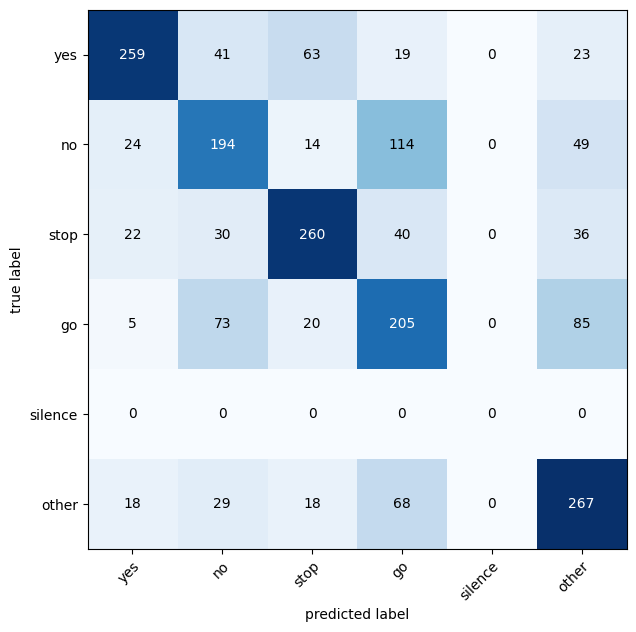

In [39]:
# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(conf_mat = confmat_tensor.numpy(), # matplotlib likes to working with numpy
                                class_names = class_names,
                                figsize = (10, 7))

# 4. Onnx export -> Inference time 비교

## 4.1 V4 Model

In [41]:
Loaded_model_v4.eval()

CNNKeywordSpotter_v4(
  (cnn): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (fc): Linear(in_features=32, out_features=6, bias=True)
)

In [43]:
# 3. 더미 입력 생성
dummy_input = torch.randn(1, 1, 32, 32)  # (Batch, Channel, Height, Width)

# 4. ONNX export
torch.onnx.export(Loaded_model_v4,
                  dummy_input,
                  "v4_model.onnx",
                  input_names=["input"],
                  output_names=["output"],
                  opset_version=13,
                  do_constant_folding=True)

In [44]:
import onnxruntime as ort
import numpy as np
import time

# 1. ONNX Runtime 세션 로드
session = ort.InferenceSession("v4_model.onnx", providers=["CPUExecutionProvider"])

# 2. 입력 이름 확인
input_name = session.get_inputs()[0].name

# 3. 더미 입력
dummy_input = np.random.rand(1, 1, 32, 32).astype(np.float32)

# 4. Warm-up
for _ in range(10):
    session.run(None, {input_name: dummy_input})

# 5. 추론 시간 측정
start = time.time()
for _ in range(100):
    session.run(None, {input_name: dummy_input})
end = time.time()

print(f"Average inference time: {(end - start)/100 * 1000:.2f} ms")

Average inference time: 0.06 ms


## 4.2 PTQ Model

In [ ]:
model_int8.eval()

CNNKeywordSpotter_v4(
  (cnn): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (fc): Linear(in_features=32, out_features=6, bias=True)
)

In [64]:
# 3. 더미 입력 생성
dummy_input = torch.randn(1, 1, 32, 32)  # (Batch, Channel, Height, Width)

# 4. ONNX export
torch.onnx.export(model_int8,
                  dummy_input,
                  "PTQ_model.onnx",
                  input_names=["input"],
                  output_names=["output"],
                  opset_version=13,
                  do_constant_folding=True)

In [66]:
import onnxruntime as ort
import numpy as np
import time

# 1. ONNX Runtime 세션 로드
session = ort.InferenceSession("PTQ_model.onnx", providers=["CPUExecutionProvider"])

# 2. 입력 이름 확인
input_name = session.get_inputs()[0].name

# 3. 더미 입력
dummy_input = np.random.rand(1, 1, 32, 32).astype(np.float32)

# 4. Warm-up
for _ in range(10):
    session.run(None, {input_name: dummy_input})

# 5. 추론 시간 측정
start = time.time()
for _ in range(100):
    session.run(None, {input_name: dummy_input})
end = time.time()

print(f"Average inference time: {(end - start)/100 * 1000:.2f} ms")

Average inference time: 0.08 ms


## 4.3 QAT Model

In [32]:
import torch

In [67]:
def strip_float_weights(model):
    for module in model.modules():
        if isinstance(module, QConv2d) or isinstance(module, QLinear):
            if hasattr(module, 'weight'):
                del module._parameters['weight']
            if hasattr(module, 'bias') and module.bias is not None:
                del module._parameters['bias']

In [68]:
strip_float_weights(Loaded_model_QAT_float)

In [69]:
Loaded_model_QAT_float.eval()

AttributeError: 'QConv2d' object has no attribute 'bias'

In [70]:
# 3. 더미 입력 생성
dummy_input = torch.randn(1, 1, 32, 32)  # (Batch, Channel, Height, Width)

# 4. ONNX export
torch.onnx.export(Loaded_model_QAT_float,
                  dummy_input,
                  "QAT_model.onnx",
                  input_names=["input"],
                  output_names=["output"],
                  opset_version=13,
                  do_constant_folding=True)

AttributeError: 'QConv2d' object has no attribute 'weight'

In [47]:
import onnxruntime as ort
import numpy as np
import time

# 1. ONNX Runtime 세션 로드
session = ort.InferenceSession("QAT_model.onnx", providers=["CPUExecutionProvider"])

# 2. 입력 이름 확인
input_name = session.get_inputs()[0].name

# 3. 더미 입력
dummy_input = np.random.rand(1, 1, 32, 32).astype(np.float32)

# 4. Warm-up
for _ in range(10):
    session.run(None, {input_name: dummy_input})

# 5. 추론 시간 측정
start = time.time()
for _ in range(100):
    session.run(None, {input_name: dummy_input})
end = time.time()

print(f"Average inference time: {(end - start)/100 * 1000:.2f} ms")


Average inference time: 0.08 ms


# 5. n_mfcc, n_mels, n_fft 값 변화

# 6. test.wav 직접 예측 -> 결과 보기